# The generic Broker class

In [ ]:
from abc import abstractmethod


class Broker(object):
	def __init__(self, host, port):
		self.host = host
		self.port = port

		self.__price_event_handler = None
		self.__order_event_handler = None
		self.__position_event_handler = None

	@property
	def on_price_event(self):
		"""
		Listeners will receive:
		symbol, bid, ask
		"""
		return self.__price_event_handler

	@on_price_event.setter
	def on_price_event(self, event_handler):
		self.__price_event_handler = event_handler

	@property
	def on_order_event(self):
		"""
		Listeners will receive:
		transaction_id
		"""
		return self.__order_event_handler

	@on_order_event.setter
	def on_order_event(self, event_handler):
		self.__order_event_handler = event_handler

	@property
	def on_position_event(self):
		"""
		Listeners will receive:
		symbol, is_long, units, unrealized_pnl, pnl
		"""
		return self.__position_event_handler

	@on_position_event.setter
	def on_position_event(self, event_handler):
		self.__position_event_handler = event_handler

	@abstractmethod
	def get_prices(self, symbols=[]):
		"""
		Query market prices from a broker
		:param symbols: list of symbols recognized by your broker
		"""
		raise NotImplementedError('Method is required!')

	@abstractmethod
	def stream_prices(self, symbols=[]):
		""""
		Continuously stream prices from a broker.
		:param symbols: list of symbols recognized by your broker
		"""
		raise NotImplementedError('Method is required!')

	@abstractmethod
	def send_market_order(self, symbol, quantity, is_buy):
		raise NotImplementedError('Method is required!')


# Oanda Broker class

In [ ]:
!pip install v20

     |████████████████████████████████| 81kB 2.6MB/s 
     |████████████████████████████████| 184kB 10.5MB/s 
  Created wheel for v20: filename=v20-3.0.25.0-cp36-none-any.whl size=85764 sha256=9cdf3be0f0eeadc677bcd03a8afc37fb9082aab7c832456663d21f62a91d799f
  Stored in directory: /root/.cache/pip/wheels/2e/e6/cf/5d1e2fc46636f8ac745eda7bc5a859ae0c5072e07ce0023e0f
Successfully built v20


In [ ]:
import v20


class OandaBroker(Broker):
	PRACTICE_API_HOST = 'api-fxpractice.oanda.com'
	PRACTICE_STREAM_HOST = 'stream-fxpractice.oanda.com'

	LIVE_API_HOST = 'api-fxtrade.oanda.com'
	LIVE_STREAM_HOST = 'stream-fxtrade.oanda.com'

	PORT = '443'

	def __init__(self, accountid, token, is_live=False):
		if is_live:
			host = self.LIVE_API_HOST
			stream_host = self.LIVE_STREAM_HOST
		else:
			host = self.PRACTICE_API_HOST
			stream_host = self.PRACTICE_STREAM_HOST

		super(OandaBroker, self).__init__(host, self.PORT)

		self.accountid = accountid
		self.token = token

		self.api = v20.Context(host, self.port, token=token)
		self.stream_api = v20.Context(stream_host, self.port, token=token)

	def get_prices(self, symbols=[]):
		response = self.api.pricing.get(
			self.accountid,
			instruments=",".join(symbols),
			snapshot=True,
			includeUnitsAvailable=False
		)
		body = response.body
		prices = body.get('prices', [])
		for price in prices:
			self.process_price(price)

	def process_price(self, price):
		symbol = price.instrument

		if not symbol:
			print('Price symbol is empty!')
			return

		bids = price.bids or []
		price_bucket_bid = bids[0] if bids and len(bids) > 0 else None
		bid = price_bucket_bid.price if price_bucket_bid else 0

		asks = price.asks or []
		price_bucket_ask = asks[0] if asks and len(asks) > 0 else None
		ask = price_bucket_ask.price if price_bucket_ask else 0

		self.on_price_event(symbol, bid, ask)

	def stream_prices(self, symbols=[]):
		response = self.stream_api.pricing.stream(
			self.accountid,
			instruments=",".join(symbols),
			snapshot=True
		)

		for msg_type, msg in response.parts():
			if msg_type == "pricing.Heartbeat":
				continue
			elif msg_type == "pricing.ClientPrice":
				self.process_price(msg)

	def send_market_order(self, symbol, quantity, is_buy):
		response = self.api.order.market(
			self.accountid,
			units=abs(quantity) * (1 if is_buy else -1),
			instrument=symbol,
			type='MARKET',
		)
		if response.status != 201:
			self.on_order_event(symbol, quantity, is_buy, None, 'NOT_FILLED')
			return

		body = response.body
		if 'orderCancelTransaction' in body:
			self.on_order_event(symbol, quantity, is_buy, None, 'NOT_FILLED')
			return
        
		transaction_id = body.get('lastTransactionID', None)
		self.on_order_event(symbol, quantity, is_buy, transaction_id, 'FILLED')

	def get_positions(self):
		response = self.api.position.list(self.accountid)
		body = response.body
		positions = body.get('positions', [])
		for position in positions:
			symbol = position.instrument
			unrealized_pnl = position.unrealizedPL
			pnl = position.pl
			long = position.long
			short = position.short

			if short.units:
				self.on_position_event(
					symbol, False, short.units, unrealized_pnl, pnl)
			elif long.units:
				self.on_position_event(
					symbol, True, long.units, unrealized_pnl, pnl)
			else:
				self.on_position_event(
					symbol, None, 0, unrealized_pnl, pnl)


# Getting prices

In [ ]:
# Replace these 2 values with your own!
ACCOUNT_ID = '101-011-15794389-001'
API_TOKEN = '035c84ad9299c6a021dcf7e69193f294-d384d2d0184ce3b43e31350aaffc9fc6'

broker = OandaBroker(ACCOUNT_ID, API_TOKEN)

In [ ]:
SYMBOL = 'EUR_USD'

In [ ]:
import datetime as dt

def on_price_event(symbol, bid, ask):
    print(
        dt.datetime.now(), '[PRICE]',
        symbol, 'bid:', bid, 'ask:', ask
    )

broker.on_price_event = on_price_event

The on_price_event() function is defined as the listener for
incoming price information and is assigned to the
broker.on_price_event event handler. We expect three values from a
pricing event – the contract symbol, the bid price, and the ask
price – which we simply print to the console.
The get_prices() method is called to fetch the current market
price from our broker:

In [ ]:
broker.get_prices(symbols=[SYMBOL])

2020-07-21 22:35:09.906375 [PRICE] EUR_USD bid: 1.15318 ask: 1.15329


# Sending a simple market order

In [ ]:
def on_order_event(symbol, quantity, is_buy, transaction_id, status):
    print(
        dt.datetime.now(), '[ORDER]',
        'transaction_id:', transaction_id,
        'status:', status,
        'symbol:', symbol,
        'quantity:', quantity,
        'is_buy:', is_buy,
    )

broker.on_order_event = on_order_event
broker.send_market_order(SYMBOL, 1, True)

2020-07-21 22:35:26.723835 [ORDER] transaction_id: 5 status: FILLED symbol: EUR_USD quantity: 1 is_buy: True


The on_order_event() function is defined as the listener for
incoming order updates from our broker and is assigned to the
broker.on_order_event event handler. For example, a limit order that
is executed, or an order that is canceled, will be called on by
this method. Finally, the send_market_order() method indicates that we are interested in buying one unit of the EUR/USD currency
pair.
If the currency markets are open when you run the preceding
codes, you should get the following result with a different
transaction ID:

The output shows that the order is successfully filled to buy
one unit of the EUR/USD currency pair with a transaction ID
of 5.

# Getting position updates

In [ ]:
def on_position_event(symbol, is_long, units, upnl, pnl):
    print(
        dt.datetime.now(), '[POSITION]',
        'symbol:', symbol,
        'is_long:', is_long,
        'units:', units,
        'upnl:', upnl,
        'pnl:', pnl
    )

broker.on_position_event = on_position_event
broker.get_positions()

2020-07-21 22:35:33.290013 [POSITION] symbol: EUR_USD is_long: True units: 1.0 upnl: -0.0001 pnl: 0.0


The on_position_event() function is defined as the listener for
incoming position updates from our broker and is assigned to
the broke.on_position_event event handler. When the get_positions()
method is called, the broker returns the position information
and triggers the following output

# Building a mean-reverting algorithmic trading system

In [ ]:
import datetime as dt
import pandas as pd


class MeanReversionTrader(object):
    def __init__(
        self, broker, symbol=None, units=1,
        resample_interval='60s', mean_periods=5
    ):
        """
        A trading platform that trades on one side
            based on a mean-reverting algorithm.

        :param broker: Broker object
        :param symbol: A str object recognized by the broker for trading
        :param units: Number of units to trade
        :param resample_interval:
            Frequency for resampling price time series
        :param mean_periods: Number of resampled intervals
            for calculating the average price
        """
        self.broker = self.setup_broker(broker)

        self.resample_interval = resample_interval
        self.mean_periods = mean_periods
        self.symbol = symbol
        self.units = units

        self.df_prices = pd.DataFrame(columns=[symbol])
        self.pnl, self.upnl = 0, 0

        self.bid_price, self.ask_price = 0, 0
        self.position = 0
        self.is_order_pending = False
        self.is_next_signal_cycle = True

    def setup_broker(self, broker):
        broker.on_price_event = self.on_price_event
        broker.on_order_event = self.on_order_event
        broker.on_position_event = self.on_position_event
        return broker

    def on_price_event(self, symbol, bid, ask):
        print(dt.datetime.now(), '[PRICE]', symbol, 'bid:', bid, 'ask:', ask)

        self.bid_price = bid
        self.ask_price = ask
        self.df_prices.loc[pd.Timestamp.now(), symbol] = (bid + ask) / 2.

        self.get_positions()
        self.generate_signals_and_think()

        self.print_state()

    def get_positions(self):
        try:
            self.broker.get_positions()
        except Exception as ex:
            print('get_positions error:', ex)

    def on_order_event(self, symbol, quantity, is_buy, transaction_id, status):
        print(
            dt.datetime.now(), '[ORDER]',
            'transaction_id:', transaction_id,
            'status:', status,
            'symbol:', symbol,
            'quantity:', quantity,
            'is_buy:', is_buy,
        )
        if status == 'FILLED':
            self.is_order_pending = False
            self.is_next_signal_cycle = False

            self.get_positions()  # Update positions before thinking
            self.generate_signals_and_think()

    def on_position_event(self, symbol, is_long, units, upnl, pnl):
        if symbol == self.symbol:
            self.position = abs(units) * (1 if is_long else -1)
            self.pnl = pnl
            self.upnl = upnl
            self.print_state()

    def print_state(self):
        print(
            dt.datetime.now(), self.symbol, self.position_state,
            abs(self.position), 'upnl:', self.upnl, 'pnl:', self.pnl
        )

    @property
    def position_state(self):
        if self.position == 0:
            return 'FLAT'
        if self.position > 0:
            return 'LONG'
        if self.position < 0:
            return 'SHORT'

    def generate_signals_and_think(self):
        df_resampled = self.df_prices\
            .resample(self.resample_interval)\
            .ffill()\
            .dropna()
        resampled_len = len(df_resampled.index)

        if resampled_len < self.mean_periods:
            print(
                'Insufficient data size to calculate logic. Need',
                self.mean_periods - resampled_len, 'more.'
            )
            return

        mean = df_resampled.tail(self.mean_periods).mean()[self.symbol]

        # Signal flag calculation
        is_signal_buy = mean > self.ask_price
        is_signal_sell = mean < self.bid_price

        print(
            'is_signal_buy:', is_signal_buy,
            'is_signal_sell:', is_signal_sell,
            'average_price: %.5f' % mean,
            'bid:', self.bid_price,
            'ask:', self.ask_price
        )

        self.think(is_signal_buy, is_signal_sell)

    def think(self, is_signal_buy, is_signal_sell):
        if self.is_order_pending:
            return

        if self.position == 0:
            self.think_when_position_flat(is_signal_buy, is_signal_sell)
        elif self.position > 0:
            self.think_when_position_long(is_signal_sell)
        elif self.position < 0: 
            self.think_when_position_short(is_signal_buy)        

    def think_when_position_flat(self, is_signal_buy, is_signal_sell):
        if is_signal_buy and self.is_next_signal_cycle:
            print('Opening position, BUY', 
                  self.symbol, self.units, 'units')
            self.is_order_pending = True
            self.send_market_order(self.symbol, self.units, True)
            return

        if is_signal_sell and self.is_next_signal_cycle:
            print('Opening position, SELL', 
                  self.symbol, self.units, 'units')
            self.is_order_pending = True
            self.send_market_order(self.symbol, self.units, False)
            return

        if not is_signal_buy and not is_signal_sell:
            self.is_next_signal_cycle = True

    def think_when_position_long(self, is_signal_sell):
        if is_signal_sell:
            print('Closing position, SELL', 
                  self.symbol, self.units, 'units')
            self.is_order_pending = True
            self.send_market_order(self.symbol, self.units, False)

    def think_when_position_short(self, is_signal_buy):
        if is_signal_buy:
            print('Closing position, BUY', 
                  self.symbol, self.units, 'units')
            self.is_order_pending = True
            self.send_market_order(self.symbol, self.units, True)

    def send_market_order(self, symbol, quantity, is_buy):
        self.broker.send_market_order(symbol, quantity, is_buy)

    def run(self):
        self.broker.stream_prices(symbols=[self.symbol])

WARNING! Running the codes below will block on the main thread! You will have to restart the kernel.

In [ ]:
trader = MeanReversionTrader(
    broker,
    resample_interval='60s',
    symbol='EUR_USD',
    units=1
)
trader.run()

2020-07-21 23:10:15.661685 [PRICE] EUR_USD bid: 1.1533 ask: 1.15338
2020-07-21 23:10:15.848256 EUR_USD LONG 1.0 upnl: 0.0 pnl: 0.0
Insufficient data size to calculate logic. Need 5 more.
2020-07-21 23:10:15.861815 EUR_USD LONG 1.0 upnl: 0.0 pnl: 0.0
2020-07-21 23:10:35.965509 [PRICE] EUR_USD bid: 1.1533 ask: 1.15338
2020-07-21 23:10:36.025570 EUR_USD LONG 1.0 upnl: 0.0 pnl: 0.0
Insufficient data size to calculate logic. Need 5 more.
2020-07-21 23:10:36.030090 EUR_USD LONG 1.0 upnl: 0.0 pnl: 0.0
2020-07-21 23:10:36.214469 [PRICE] EUR_USD bid: 1.15331 ask: 1.15339
2020-07-21 23:10:36.276493 EUR_USD LONG 1.0 upnl: 0.0 pnl: 0.0
Insufficient data size to calculate logic. Need 5 more.
2020-07-21 23:10:36.280896 EUR_USD LONG 1.0 upnl: 0.0 pnl: 0.0
2020-07-21 23:10:36.467169 [PRICE] EUR_USD bid: 1.1533 ask: 1.15338
2020-07-21 23:10:36.523817 EUR_USD LONG 1.0 upnl: 0.0 pnl: 0.0
Insufficient data size to calculate logic. Need 5 more.
2020-07-21 23:10:36.528349 EUR_USD LONG 1.0 upnl: 0.0 pnl: 0.0

KeyboardInterrupt: ignored

# Building a trend-following trading platform

First, we resample raw tick-level data into standard time series
intervals, for example, at one-minute intervals. Second, taking
a number of the most recent periods, for example, with five
periods, we calculate the short-term average price for the past
five minutes. Finally, taking a larger number of the most
recent periods, for example, with ten periods, we calculate the
long-term average price for the past ten minutes.
In a market with no movement, the average short-term price
should be the same as the average long-term price with a ratio
of one – this ratio is also known as the beta. When the average
short-term price increases more than the average long-term
price, the beta is more than one and the market can be viewed
as on an uptrend. When the short-term price decreases more than the average long-term price, the beta is less than one and
the market can be viewed as on a downtrend

In [ ]:
class TrendFollowingTrader(MeanReversionTrader):
	def __init__(
		self, *args, long_mean_periods=10,
		buy_threshold=1.0, sell_threshold=1.0, **kwargs
	):
		super(TrendFollowingTrader, self).__init__(*args, **kwargs)

		self.long_mean_periods = long_mean_periods
		self.buy_threshold = buy_threshold
		self.sell_threshold = sell_threshold

	def generate_signals_and_think(self):
		df_resampled = self.df_prices\
			.resample(self.resample_interval)\
			.ffill().dropna()
		resampled_len = len(df_resampled.index)

		if resampled_len < self.long_mean_periods:
			print(
				'Insufficient data size to calculate logic. Need',
				self.mean_periods - resampled_len, 'more.'
			)
			return

		mean_short = df_resampled\
			.tail(self.mean_periods).mean()[self.symbol]
		mean_long = df_resampled\
			.tail(self.long_mean_periods).mean()[self.symbol]
		beta = mean_short / mean_long

		# Signal flag calculation
		is_signal_buy = beta > self.buy_threshold
		is_signal_sell = beta < self.sell_threshold

		print(
			'is_signal_buy:', is_signal_buy,
			'is_signal_sell:', is_signal_sell,
			'beta:', beta,
			'bid:', self.bid_price,
			'ask:', self.ask_price
		)

		self.think(is_signal_buy, is_signal_sell)

WARNING! Running the codes below will block on the main thread! You will have to restart the kernel.

In [ ]:
trader = TrendFollowingTrader(
    broker,
    resample_interval='60s',
    symbol='EUR_USD',
    units=1,
    mean_periods=5,
    long_mean_periods=10,
    buy_threshold=1.000010,
    sell_threshold=0.99990,
)
trader.run()

2020-07-22 00:14:12.569692 [PRICE] EUR_USD bid: 1.15343 ask: 1.15351
2020-07-22 00:14:12.640318 EUR_USD SHORT 1.0 upnl: 0.0 pnl: -0.0018
Insufficient data size to calculate logic. Need 5 more.
2020-07-22 00:14:12.644607 EUR_USD SHORT 1.0 upnl: 0.0 pnl: -0.0018
2020-07-22 00:14:13.572058 [PRICE] EUR_USD bid: 1.1534 ask: 1.1535
2020-07-22 00:14:13.635914 EUR_USD SHORT 1.0 upnl: 0.0 pnl: -0.0018
Insufficient data size to calculate logic. Need 5 more.
2020-07-22 00:14:13.640362 EUR_USD SHORT 1.0 upnl: 0.0 pnl: -0.0018
2020-07-22 00:14:17.833487 [PRICE] EUR_USD bid: 1.15343 ask: 1.15352
2020-07-22 00:14:17.901676 EUR_USD SHORT 1.0 upnl: 0.0 pnl: -0.0018
Insufficient data size to calculate logic. Need 5 more.
2020-07-22 00:14:17.907107 EUR_USD SHORT 1.0 upnl: 0.0 pnl: -0.0018
2020-07-22 00:14:18.093751 [PRICE] EUR_USD bid: 1.15345 ask: 1.15353
2020-07-22 00:14:18.156452 EUR_USD SHORT 1.0 upnl: 0.0 pnl: -0.0018
Insufficient data size to calculate logic. Need 5 more.
2020-07-22 00:14:18.160847

KeyboardInterrupt: ignored

# VaR for risk management

In [ ]:
!pip install yahoo_fin
!pip install requests_html

In [38]:
from yahoo_fin.stock_info import get_data

In [40]:
df= get_data("AAPL",#start_date = '01/03/2000',
                      index_as_date = True, interval="1d")
df

,open,high,low,close,adjclose,volume,ticker
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.405683,117258400.0,AAPL
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.384517,43971200.0,AAPL
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.356296,26432000.0,AAPL
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.365115,21610400.0,AAPL
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.375698,18362400.0,AAPL
...,...,...,...,...,...,...,...
2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500.0,AAPL
2020-07-16,386.250000,389.619995,383.619995,386.089996,386.089996,27644400.0,AAPL
2020-07-17,387.950012,388.589996,383.359985,385.309998,385.309998,23046700.0,AAPL
2020-07-20,385.670013,394.000000,384.250000,393.429993,393.429993,22531700.0,AAPL


In [46]:
from pylab import rcParams
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import init_notebook_mode, iplot

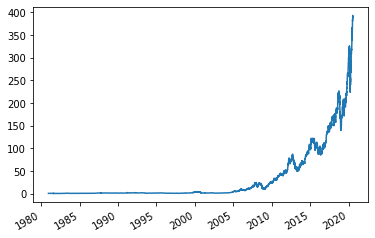

In [43]:
df.adjclose.plot()

In [48]:
time='2020'
newdf=df[time]
trace = go.Candlestick(x=newdf.index,
                open=newdf.open,
                high=newdf.high,
                low=newdf.low,
                close=newdf.close)
data = [trace]
iplot(data, filename='simple_candlestick')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9986 entries, 1980-12-12 to 2020-07-21
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      9985 non-null   float64
 1   high      9985 non-null   float64
 2   low       9985 non-null   float64
 3   close     9985 non-null   float64
 4   adjclose  9985 non-null   float64
 5   volume    9985 non-null   float64
 6   ticker    9986 non-null   object 
dtypes: float64(6), object(1)
memory usage: 624.1+ KB


In [49]:
import datetime as dt
import pandas as pd
 
# Define the date range
start = dt.datetime(2017, 1, 1)
end = dt.datetime(2017, 12, 31)
 
# Cast indexes as DateTimeIndex objects
df.index = pd.to_datetime(df.index)
closing_prices = df['adjclose']
prices = closing_prices.loc[start:end]
prices

2017-01-03    110.392334
2017-01-04    110.268791
2017-01-05    110.829552
2017-01-06    112.065109
2017-01-09    113.091560
                 ...    
2017-12-22    169.009430
2017-12-26    164.721680
2017-12-27    164.750641
2017-12-28    165.214188
2017-12-29    163.427597
Name: adjclose, Length: 251, dtype: float64

Value at risk (VaR) is a measure of the risk of loss for investments. It estimates how much a set of investments might lose (with a given probability), given normal market conditions, in a set time period such as a day.

VaR for risk management

As soon as we open a position in the market, we are exposed to
various types of risks, such as volatility risk and credit risk. To
preserve our trading capital as much as possible, it is
important to incorporate some form of risk management
measures to our trading system.

Perhaps the most common measure of risk used in the
financial industry is the VaR technique. It is designed to
simply answer the following question: What is the worst
expected amount of loss, given a specific probability level, say
95%, over a certain period of time? The beauty of VaR is that
it can be applied to multiple levels, from position-specific
micro-level to portfolio-based macro-level. For example, a VaR
of 1 million with a 95% confidence level for a 1-day time
horizon states that, on average, only 1 day out of 20 could you
expect to lose more than $1 million due to market movements.

The following diagram illustrates a normally distributed
portfolio returns with a mean of 0%, where VaR is the loss
corresponding to the 95th percentile of the distribution of
portfolio returns:

In [50]:
from scipy.stats import norm

def calculate_daily_var(
    portfolio, prob, mean, 
    stdev, days_per_year=252.
):
    alpha = 1-prob
    u = mean/days_per_year
    sigma = stdev/np.sqrt(days_per_year)
    norminv = norm.ppf(alpha, u, sigma)
    return portfolio - portfolio*(norminv+1)

In [51]:
import numpy as np

portfolio = 100000000.00
confidence = 0.95
 
daily_returns = prices.pct_change().dropna()
mu = np.mean(daily_returns)
sigma = np.std(daily_returns)

In [53]:
daily_returns

2017-01-04   -0.001119
2017-01-05    0.005085
2017-01-06    0.011148
2017-01-09    0.009159
2017-01-10    0.001009
                ...   
2017-12-22    0.000000
2017-12-26   -0.025370
2017-12-27    0.000176
2017-12-28    0.002814
2017-12-29   -0.010814
Name: adjclose, Length: 250, dtype: float64

In [54]:
mu

0.0016317126113286613

In [55]:
sigma

0.011090289519299525

Hand manual calculation:

In [56]:
portfolio= 100000000.00
prob= 0.95
mean = mu
stdev = sigma
days_per_year=252.

alpha = 1-prob #0.05
u = mean/days_per_year # 6.47 e-06
sigma = stdev/np.sqrt(days_per_year) # 0.00069
norminv = norm.ppf(alpha, u, sigma) # - 0.00114
# PPF (q) of the standard normal distribution for the probability (1 – α) = 0.95

VaR= portfolio - portfolio*(norminv+1)

print('alpha',alpha)
print('u',u)
print('sigma',sigma)
print('norminv',norminv)
print('VaR',VaR)

alpha 0.050000000000000044
u 6.475050044955006e-06
sigma 0.0006986225722803002
norminv -0.0011426568218404637
VaR 114265.68218404055


ppf 

Returns a 95% significance interval for a one-tail test on a standard normal distribution (i.e. a special case of the normal distribution where the mean is 0 and the standard deviation is 1).

norm.ppf(0.95, loc=172.7815, scale=4.1532)

This will return a value (that functions as a 'standard-deviation multiplier') marking where 95% of data points would be contained if our data is a normal distribution.

To get the exact number, we take the norm.ppf() output and multiply it by our standard deviation for the distribution in question.

In [57]:
cdf=norm.cdf(-0.00114,u, sigma) # x=-0.00114
cdf
#CDF of the standard normal distribution (μ = u and σ = sigma).
#Probability of less than x = - 0.00114 is equal to 0.05039


0.0503934472971221

CDF of the standard normal distribution (μ = 0 and σ = 0.000698).

Probability of less than x = -0.00114 is equal to 0.05

Auto

In [52]:
VaR = calculate_daily_var(
    portfolio, confidence, mu, sigma, days_per_year=252.)
print('Value-at-Risk: %.2f' % VaR)

Value-at-Risk: 114265.68


Assuming 252 trading days per year, the daily VaR of 2017 for
the stock AAPL with 95% confidence is $114,248.72.